In [9]:
import matplotlib.pyplot as plt
import numpy as np
from plyfile import PlyData
import open3d as o3d

In [2]:
surface2 = PlyData.read('Image0009.ply')
vertices = surface2['vertex'].data
faces = surface2['face'].data

In [3]:
surface2

PlyData((PlyElement('vertex', (PlyProperty('x', 'float'), PlyProperty('y', 'float'), PlyProperty('z', 'float')), count=65536, comments=[]), PlyElement('face', (PlyListProperty('vertex_index', 'uchar', 'int'),), count=130050, comments=[])), text=True, byte_order='=', comments=['exported from Gwyddion', 'title HeightRetrace'], obj_info=[])

In [42]:
vertices

array([(  0.,   0., 26.882784), (  1.,   0., 27.028566),
       (  2.,   0., 27.447363), ..., (253., 255., 13.016548),
       (254., 255., 11.755153), (255., 255., 10.47204 )],
      dtype=[('x', '<f4'), ('y', '<f4'), ('z', '<f4')])

In [5]:
faces

array([(array([  0, 257, 256]),), (array([  0,   1, 257]),),
       (array([  1, 258, 257]),), ..., (array([65277, 65278, 65534]),),
       (array([65278, 65535, 65534]),), (array([65278, 65279, 65535]),)],
      dtype=[('vertex_index', 'O')])

In [10]:
pcd = o3d.io.read_point_cloud('Image0009.ply')
o3d.visualization.draw_geometries([pcd])

In [11]:
def compute_normal(A, B, C):
    AB = B - A
    AC = C - A
    N = np.cross(AB, AC)
    return N / np.linalg.norm(N)  # Normalized normal

In [47]:
vertices_np = np.array(vertices.tolist())
faces_np = np.array([face[0] for face in faces])
A = vertices_np[faces_np[:, 0]]
B = vertices_np[faces_np[:, 1]]
C = vertices_np[faces_np[:, 2]]
# Calculate edge vectors
AB = B - A
AC = C - A
# Compute normals
normals = np.cross(AB, AC)
# Normalize the normals
normals = normals / np.linalg.norm(normals, axis=1)[:, np.newaxis]

[[    0   257   256]
 [    0     1   257]
 [    1   258   257]
 ...
 [65277 65278 65534]
 [65278 65535 65534]
 [65278 65279 65535]]


In [22]:
normals

array([[-0.26106911,  0.489305  ,  0.8321199 ],
       [-0.13320791,  0.38383194,  0.91374433],
       [-0.39667893,  0.35550964,  0.8463207 ],
       ...,
       [ 0.80488174,  0.02952603,  0.59270026],
       [ 0.78837944,  0.03060839,  0.61442736],
       [ 0.82159479, -0.06699511,  0.56612159]])

(-1.0, 81.0)

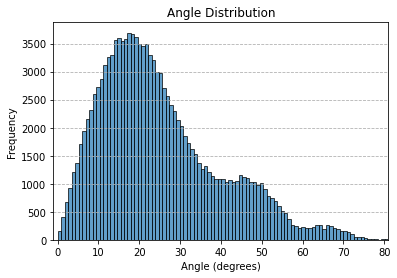

In [49]:
z_norm = np.array([0, 0, 1])
dot_products = np.dot(normals, z_norm)
cosine_angles = dot_products
# Compute the angles using arccosine (result is in radians)
angles_radians = np.arccos(np.clip(cosine_angles, -1.0, 1.0))
# If you want the angles in degrees
angles_degrees = np.degrees(angles_radians)

plt.hist(angles_degrees, bins=100, edgecolor='black', alpha=0.7)
plt.title('Angle Distribution')
plt.xlabel('Angle (degrees)')
plt.ylabel('Frequency')
plt.grid(axis='y', linestyle='--')
plt.xlim(-1, 81)

In [45]:
max(vertices_np[:, 2])

63.54817581176758

In [46]:
min(vertices_np[:, 2])


0.0

In [ ]:
surface_test = PlyData.read('Image0009.ply')
vertices_test = surface2['vertex'].data